In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [119]:
housing_data = pd.read_csv('Bangalore.csv')
housing_data.head() 

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,30000000,3340,JP Nagar Phase 1,4,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,4866000,1179,Kannur on Thanisandra Main Road,2,0,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,8358000,1675,Doddanekundi,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,6845000,1670,Kengeri,3,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0


In [120]:
varlist = ['Price','Area','No. of Bedrooms','Resale','MaintenanceStaff','Gymnasium','SwimmingPool','LandscapedGardens','IndoorGames']
data = housing_data[varlist].copy()

In [121]:
# checking for null values
print(data.info())

# checking for outliers
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6207 entries, 0 to 6206
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Price              6207 non-null   int64
 1   Area               6207 non-null   int64
 2   No. of Bedrooms    6207 non-null   int64
 3   Resale             6207 non-null   int64
 4   MaintenanceStaff   6207 non-null   int64
 5   Gymnasium          6207 non-null   int64
 6   SwimmingPool       6207 non-null   int64
 7   LandscapedGardens  6207 non-null   int64
 8   IndoorGames        6207 non-null   int64
dtypes: int64(9)
memory usage: 436.5 KB
None
              Price         Area  No. of Bedrooms       Resale  \
count  6.207000e+03  6207.000000      6207.000000  6207.000000   
mean   1.058510e+07  1526.094248         2.556952     0.078782   
std    1.410943e+07   764.845609         0.694300     0.269420   
min    2.000000e+06   415.000000         1.000000     0.000000   
25%    5.0000

In [127]:
# splitting the data into training and testing data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
train_to_test_ratio
size = int(train_to_test_ratio * len(data))

data_train = data[size:]
data_test = data[size:]

y_train = data[varlist[0]]
x_train = data[varlist[1:]]

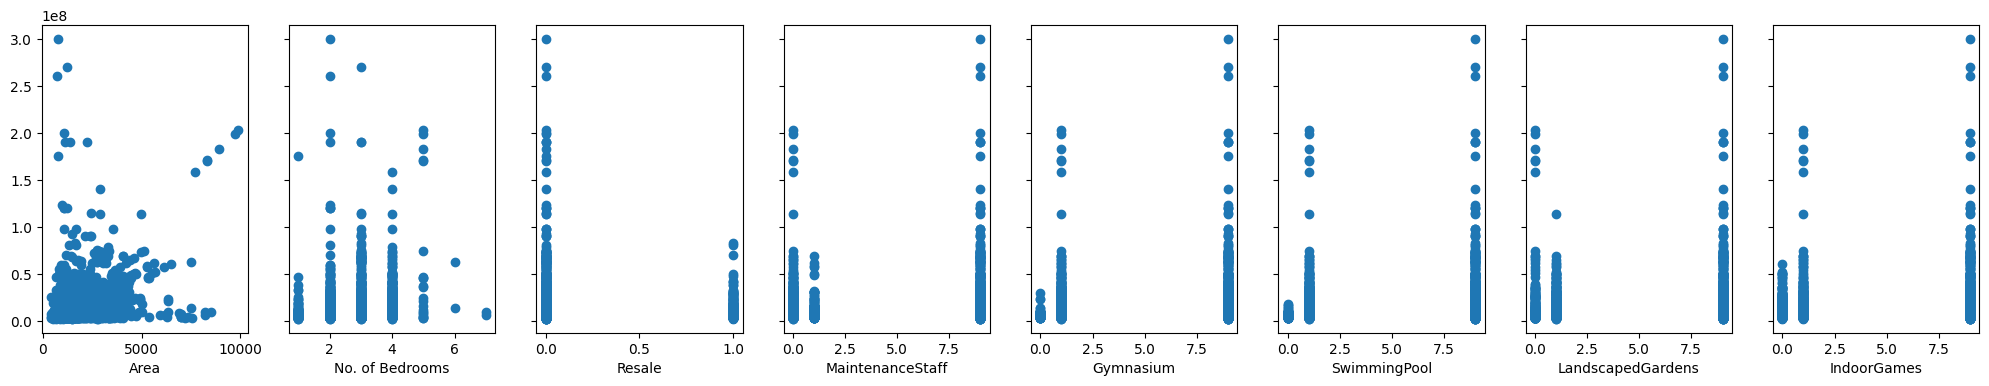

In [128]:
# plotting the to check if scaling is required
fig,ax = plt.subplots(1,8, figsize=(25,4), sharey = True)
for i in range(len(ax)):
    ax[i].scatter(x_train[varlist[i+1]],y_train)
    ax[i].set_xlabel(varlist[i+1])

In [132]:
# all the features are scaled except Area
# performing z-score normalization on Area
std_dev = np.std(x_train.Area)
mean = np.mean(x_train.Area)

for i in range(x_train.shape[0]):
    area = x_train.loc[i,'Area']
    area = (a - mean)/std_dev
    x_train.loc[i,'Area'] = area
